In [144]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [145]:
def thresholding(D, threshold): # 0 or 255 since the threshold
    R, G, B = 0, 1, 2

    width_D, height_D= D.shape
    thresholdImg = np.copy(D)
    for row in range(width_D):
        for column in range(height_D):
            if(D[row][column]>threshold):
                thresholdImg[row][column] = 0
            else:
                thresholdImg[row][column] = 1
    
    return thresholdImg

def thresholdOtsu(img): #min(weightB*VarianceB + weightF*VarianceF)
    #Histogram
    hist = np.zeros(256)
    for row in range(img.shape[0]):
        for column in range(img.shape[1]):
            hist[img[row][column]] += 1
    
    pixelesInImg = img.shape[0]*img.shape[1]
    WCVList = []

    #Algorithm
    for threshold in range(len(hist)):
        #b where hist < threshold
        b = hist[:threshold]
        #Weight b
        w_b = sum(b)/(pixelesInImg)
        #Mean b
        m = 0
        for i in range(threshold):
            m += (i*hist[i])
        if(sum(b)==0):
            m_b = 0
        else:
            m_b = m/sum(b)
        #Variance b
        v = 0
        for i in range(threshold):
            v += ((i-m_b)**2) * hist[i]
        if(sum(b)==0):
            v_b = 0
        else:
            v_b = v/sum(b)

        #f where hist >= threshold
        f = hist[threshold:]
        #Weight f
        w_f = sum(f)/(pixelesInImg)
        #Mean f
        m = 0
        for i in range(threshold, len(hist)):
            m += (i*hist[i])
        m_f = m/sum(f)
        #Variance f
        v = 0
        for i in range(threshold, len(hist)):
            v += ((i-m_f)**2) * hist[i]
        v_f = v/sum(f)
        #Within_class_variance
        WCV = (w_b*v_b)+(w_f*v_f)
        WCVList.append(WCV)
        
    t = WCVList.index(min(WCVList))
    imagen = thresholding(img,t)
    return imagen #The rigth threshold

In [146]:
def etiquetas_u(imagen):
    etiquetas = np.zeros_like(imagen)  # Matriz para almacenar las etiquetas

    etiqueta_actual = 1  # La primera etiqueta que usaremos

    # Iterar sobre cada píxel de la imagen
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            # Si el píxel es parte de un componente conectado
            if imagen[i, j] == 0:
                vecinos_etiquetas = []  # Etiquetas de los vecinos

                # Verificar vecinos en la parte superior e izquierda
                for x, y in [(i - 1, j), (i, j - 1)]:
                    if 0 <= x < imagen.shape[0] and 0 <= y < imagen.shape[1]:
                        if etiquetas[x, y] != 0:
                            vecinos_etiquetas.append(etiquetas[x, y])

                # Si no hay vecinos etiquetados, asignar una nueva etiqueta
                if not vecinos_etiquetas:
                    etiquetas[i, j] = etiqueta_actual
                    etiqueta_actual += 1
                else:
                    # Asignar la etiqueta mínima de los vecinos
                    etiquetas[i, j] = min(vecinos_etiquetas)
    print(etiqueta_actual)
    return etiquetas

In [153]:
def inicializar_union_find(n):
    parent = list(range(n))
    rank = [0] * n
    return parent, rank

# Función para encontrar el representante de un conjunto
def encontrar_representante(x, parent):
    if parent[x] == x:
        return x
    parent[x] = encontrar_representante(parent[x], parent)  # Compresión de ruta
    return parent[x]

# Función para unir dos conjuntos
def unir_conjuntos(x, y, parent, rank):
    x_root = encontrar_representante(x, parent)
    y_root = encontrar_representante(y, parent)

    if x_root != y_root:
        if rank[x_root] < rank[y_root]:
            parent[x_root] = y_root
        elif rank[x_root] > rank[y_root]:
            parent[y_root] = x_root
        else:
            parent[y_root] = x_root
            rank[x_root] += 1

# Definir una función para encontrar componentes conectados utilizando Union-Find
def etiquetas_color(imagen):
    etiquetas = np.zeros_like(imagen)  # Matriz para almacenar las etiquetas
    parent, rank = inicializar_union_find(imagen.shape[0] * imagen.shape[1])

    etiqueta_actual = 1  # La primera etiqueta que usaremos

    # Iterar sobre cada píxel de la imagen
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            # Si el píxel es parte de un componente conectado
            if imagen[i, j] == 1:
                vecinos_etiquetas = []  # Etiquetas de los vecinos

                # Verificar vecinos en la parte superior e izquierda
                for x, y in [(i - 1, j), (i, j - 1)]:
                    if 0 <= x < imagen.shape[0] and 0 <= y < imagen.shape[1] and imagen[x, y] == 1:
                        vecinos_etiquetas.append(etiquetas[x, y])

                # Si no hay vecinos etiquetados, asignar una nueva etiqueta
                if not vecinos_etiquetas:
                    etiquetas[i, j] = etiqueta_actual
                    etiqueta_actual += 1
                else:
                    # Asignar la etiqueta mínima de los vecinos
                    etiquetas[i, j] = min(vecinos_etiquetas)

                    # Unir los conjuntos de etiquetas de los vecinos
                    for etiqueta_vecino in vecinos_etiquetas:
                        unir_conjuntos(etiquetas[i, j], etiqueta_vecino, parent, rank)

    # Actualizar las etiquetas para que sean continuas
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if etiquetas[i, j] != 0:
                etiquetas[i, j] = encontrar_representante(etiquetas[i, j], parent)

    return etiquetas

In [148]:
def colores (imagen,etiquetas):
    rows, cols = imagen.shape
    imagen_color = np.zeros((rows, cols, 3), dtype=np.uint8)

    # Asignar colores aleatorios a cada componente conectado
    colores = {}
    for i in range(rows):
        for j in range(cols):
            if etiquetas[i, j] not in colores and etiquetas[i, j] != 0:
                colores[etiquetas[i, j]] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            if etiquetas[i, j] != 0:
                imagen_color[i, j] = colores[etiquetas[i, j]]
    return imagen_color

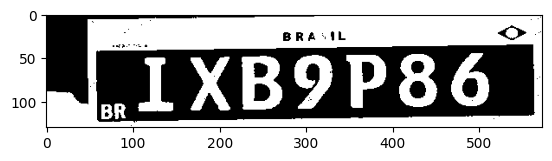

C:\Users\nanga\AppData\Local\Temp\ipykernel_25132\2044064999.py:21: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  etiquetas[i, j] = etiqueta_actual


257


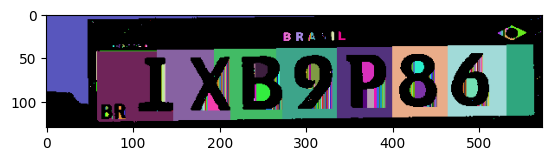

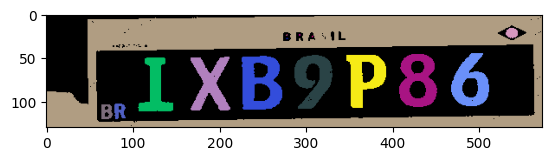

In [154]:
imagen1 = cv2.imread('Nuev_placas/recorte7.jpg', cv2.IMREAD_GRAYSCALE)
imagen= thresholdOtsu(imagen1)
plt.imshow(imagen,cmap='gray')
plt.show()
etiquetas = etiquetas_u(imagen)
etiquetas1 = etiquetas_color(imagen)
imagen_color = colores(imagen,etiquetas)
imagen_color1 = colores(imagen,etiquetas1)


# Mostrar la imagen etiquetada
plt.imshow( imagen_color)
plt.show()
plt.imshow( imagen_color1)
plt.show()